<a href="https://colab.research.google.com/github/Qargo/Experimentation/blob/main/StockPricePrediction_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Experiment 1
This is experiment in using machine learning for stock closing price prediction. For prediction we will be constracting recurent neural network LSTM  using TensorFlow 2.0.

In [89]:
# Lets check if we have all packages installed, and if not lets install them
import pkg_resources
installedPackages = {pkg.key for pkg in pkg_resources.working_set}
required = {'yfinance', 'pandas', 'math', 'numpy'}
missing = required - installedPackages
if missing:
    !pip install yfinance

In [99]:
# Import libraries
import math
import numpy as np
import pandas as pd
import yfinance as yahoo 
import datetime as datetime
import pandas_datareader as web
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras. layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

np.random.seed(777)

Get the selected stock data

In [100]:
data_source = 'yahoo'

if data_source == 'yahoo':
    yahoo.pdr_override()


In order to change which stock you want to use, update stocks[ ]. We first need to collect historical data in order to train our neural network. 

In [101]:
# download dataframes using pandas_datareader
def get_symbols(data_source, symbols, begin_date=None, end_date=None):
    out = pd.DataFrame()
    for symbol in symbols:
        df = web.DataReader(symbol, data_source, begin_date, end_date)
        df.head()
        df.columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close']
        df['Ticker'] = symbol
        df['Date'] = pd.to_datetime(df.index, format='%Y-%m-%d')
        out = pd.concat([out, df], axis=0)
    return out

# start_date = datetime.date.today() - datetime.timedelta(60)
# end_date = datetime.date.today()

start_date = datetime.date(2010, 1, 1)
end_date = datetime.date.today()

stocks = ['AAPL']

print ("Start date:", start_date);
print ("End date:", end_date)

data = get_symbols(data_source, stocks, begin_date=start_date, end_date=end_date)

data.head()

Start date: 2010-01-01
End date: 2021-01-10


,Open,High,Low,Close,Volume,Adj Close,Ticker,Date
Date,,,,,,,,
2010-01-04,7.660714,7.585000,7.622500,7.643214,493729600.0,6.593423,AAPL,2010-01-04
2010-01-05,7.699643,7.616071,7.664286,7.656429,601904800.0,6.604822,AAPL,2010-01-05
2010-01-06,7.686786,7.526786,7.656429,7.534643,552160000.0,6.499765,AAPL,2010-01-06
2010-01-07,7.571429,7.466071,7.562500,7.520714,477131200.0,6.487749,AAPL,2010-01-07
2010-01-08,7.571429,7.466429,7.510714,7.570714,447610800.0,6.530882,AAPL,2010-01-08


In [102]:
data.shape

(2774, 8)

Create the visualization of the data.

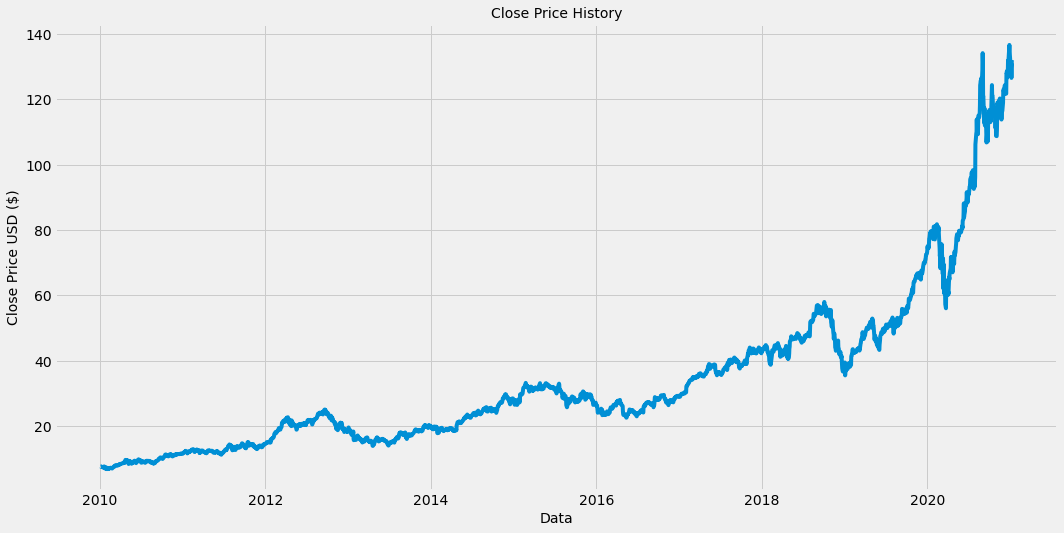

In [103]:
# Visualize the closing price history
plt.figure(figsize=(16, 8))
plt.title('Close Price History', fontsize=14)
plt.plot(data['Close'])
plt.xlabel('Data', fontsize=14)
plt.ylabel('Close Price USD ($)', fontsize=14)
plt.show()

Create new data frame with only closing price and convert it into array.

In [104]:
# Create a new dataframe
new_data = data.filter(['Close'])
# Convert dataframe in to a numpy array
dataset = new_data.values

# We are going to use 80% of dataset to train the neural network
training_data_len = math.ceil(len(dataset)*0.8)
training_data_len

2220

In [105]:
# Now scale the dataset to be values between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset) 

scaled_data

array([[0.00604081],
       [0.00614259],
       [0.00520456],
       ...,
       [0.9222836 ],
       [0.9555576 ],
       [0.96426126]])

Now lets create scaled training dataset based on the past 60 days closing price value that we are going to use in order to predict 61st closing price value.

In [106]:
# Create the traning dataset
train_data = scaled_data[0:training_data_len,:]

# Split the data into x_train and y_train
x_train = []
y_train = []

for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i, 0])
  y_train.append(train_data[i, 0])

# convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# reshape the data into the shape accepted by the LSTM
x_train = np.reshape(x_train,(x_train.shape[0], x_train.shape[1],1)) 

Lets build our LSTM neural network. Our model will have two LSTM layers with 50 neurons and two dense layers, one with 25 neurons and the other with 1 neuron

In [107]:
# Build the LSTM network model
#model = Sequential()
#model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
#model.add(LSTM(50, return_sequences=False))
#model.add(Dense(units=25))
#model.add(Dense(units=1))

model = Sequential()
model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

# compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

Lets train our LSTM model

In [108]:
# Train the model
#model.fit(x_train, y_train, epochs=5, batch_size=1)
model.fit(x_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
68/68 [==============================] - 13s 107ms/step - loss: 0.0044
Epoch 2/100
68/68 [==============================] - 8s 111ms/step - loss: 3.6324e-04
Epoch 3/100
68/68 [==============================] - 8s 115ms/step - loss: 3.8784e-04
Epoch 4/100
68/68 [==============================] - 8s 114ms/step - loss: 3.0005e-04
Epoch 5/100
68/68 [==============================] - 8s 117ms/step - loss: 3.0799e-04
Epoch 6/100
68/68 [==============================] - 8s 119ms/step - loss: 3.2060e-04
Epoch 7/100
68/68 [==============================] - 8s 119ms/step - loss: 2.4124e-04
Epoch 8/100
68/68 [==============================] - 8s 116ms/step - loss: 2.9879e-04
Epoch 9/100
68/68 [==============================] - 8s 116ms/step - loss: 2.2876e-04
Epoch 10/100
68/68 [==============================] - 8s 117ms/step - loss: 2.7983e-04
Epoch 11/100
68/68 [==============================] - 8s 118ms/step - loss: 2.1520e-04
Epoch 12/100
68/68 [==============================] - 8

Create test dataset

In [109]:
# Test data set
test_data = scaled_data[training_data_len - 60:,:]

# Create the x_test adn y_test data set
x_test = []
y_test = dataset[training_data_len:,:]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

# convert x_test to a numpy array
x_test = np.array(x_test)

# reshape the data into shape acceted by the LSTM
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

Get the predicted values from the model using the test data.

In [110]:
# Getting the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

Lets see how good did model performed.

In [111]:
# calculate value of RMSE
rmse = np.sqrt(np.mean(((predictions - y_test)**2)))
rmse 

5.908388800063696

Lets visulize the predictions

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


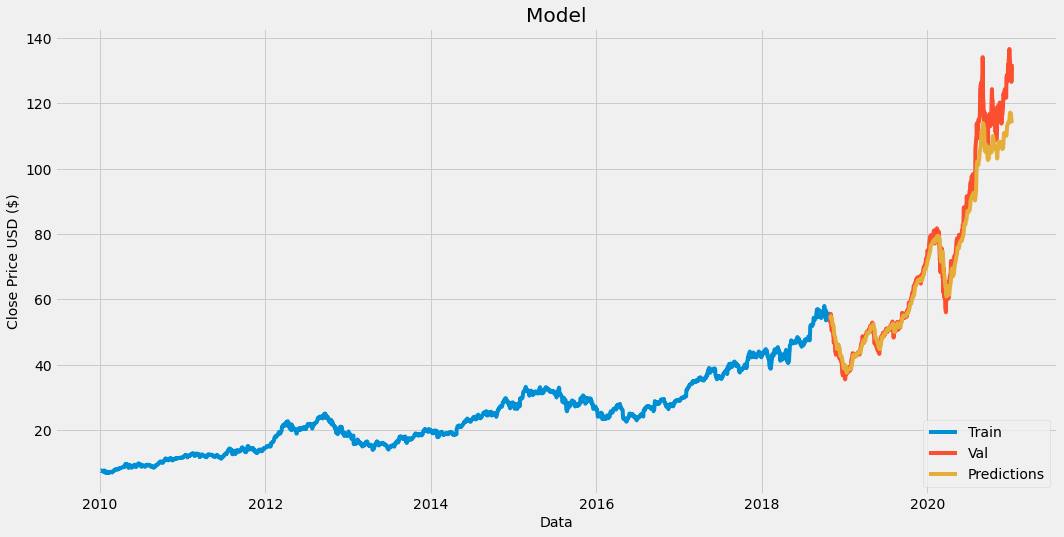

In [112]:
# plot the data for the graph
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Data', fontsize=14)
plt.ylabel('Close Price USD ($)', fontsize=14)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [88]:
# Show the valid and predictions
valid

,Open,High,Low,Close,Volume,Adj Close,Ticker,Date,Predictions
Date,,,,,,,,,
2018-10-26,55.047501,53.167500,53.974998,54.075001,189033600.0,52.634758,AAPL,2018-10-26,52.579334
2018-10-29,54.922501,51.522499,54.797501,53.060001,183742000.0,51.646793,AAPL,2018-10-29,51.836857
2018-10-30,53.794998,52.317501,52.787498,53.325001,146640000.0,51.904736,AAPL,2018-10-30,50.873322
2018-10-31,55.112499,54.154999,54.220001,54.715000,153435600.0,53.257713,AAPL,2018-10-31,51.141987
2018-11-01,55.590000,54.202499,54.762501,55.555000,233292800.0,54.075333,AAPL,2018-11-01,52.527851
...,...,...,...,...,...,...,...,...,...
2021-01-04,133.610001,126.760002,133.520004,129.410004,143301900.0,129.410004,AAPL,2021-01-04,123.313484
2021-01-05,131.740005,128.429993,128.889999,131.009995,97664900.0,131.009995,AAPL,2021-01-05,120.091820
2021-01-06,131.050003,126.379997,127.720001,126.599998,155088000.0,126.599998,AAPL,2021-01-06,122.417702
